# Tutorial

This repository contains several utility functions that enable easier analysis across
CMIP6 model data.

It offers solutions to the following problems:

1. [Inconsistent naming of dimensions and coordinates](#rename)
2. [Inconsistent values,shape and dataset location of coordinates](#coords)
3. [Inconsistent longitude conventions](#lon)
4. [Inconsistent units](#units)
5. [Inconsistent longitude/latitude bounds](#bounds)
<!-- 5. [Missing grid metrics](#metrics) -->
<!-- 6. [Variables on staggered grids](#grids) -->
5. [TL;DR How to put it all together](#combo)

In [1]:
import matplotlib.pyplot as plt
import intake
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

<a id="rename"></a>
## Inconsistent naming of dimensions and coordinates
All cmip6 models (except for the unstructured grid of the AWI model) have in principal the same datastructure and **should** have a consistent naming, such that the user can test an analysis on one model and then seamlessly apply it on another. In practice some models have alternate naming for e.g. the logical (x,y,z) dimensions. `cmip6_preprocessing.preprocessing.rename_cmip6` accesses an internal dictionary to rename all models consistently to the following scheme:

- `x`, `y`,`lev` for the logical grid index in the x,y,z direction
- `lon`, `lat` for geographical position coordinates
- `bnds`, `vertex` for cell bounds or vertex indicies
- `time_bounds`, `lev_bounds`, `lon_bounds`, `lat_bounds` for cell bounding values

In [3]:
# load a few models to illustrate the problem
query = dict(experiment_id=['piControl'], table_id='Oyr', 
             variable_id='o2', grid_label=['gn', 'gr'],
             source_id=['IPSL-CM6A-LR', 'CanESM5', 'GFDL-ESM4']
            )
cat = col.search(**query)

cat.df['source_id'].unique()
z_kwargs = {'consolidated': True, 'decode_times':False}
dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs)#


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 3 group(s)


In [5]:
# show coordinates
for k, ds in dset_dict.items():
    print(k)
    print(list(ds.dims))

CMIP.CCCma.CanESM5.piControl.Oyr.gn
['bnds', 'i', 'j', 'lev', 'member_id', 'time', 'vertices']
CMIP.IPSL.IPSL-CM6A-LR.piControl.Oyr.gn
['axis_nbounds', 'member_id', 'nvertex', 'olevel', 'time', 'x', 'y']
CMIP.NOAA-GFDL.GFDL-ESM4.piControl.Oyr.gr
['bnds', 'lat', 'lev', 'lon', 'member_id', 'time']


You can see that e.g. the x dimension is not consistently labelled. E.g. in one model it is called `i` in the other `x`. We can fix this by passing `rename_cmip6` as `preprocess` argument to `to_dataset_dict`:

In [6]:
from cmip6_preprocessing.preprocessing import rename_cmip6

# load a few models to illustrate the problem
cat = col.search(**query)
cat.df['source_id'].unique()


# pass the preprocessing directly
dset_dict_renamed = cat.to_dataset_dict(zarr_kwargs=z_kwargs, preprocess=rename_cmip6)

for k, ds in dset_dict_renamed.items():
    print(k)
    print(list(ds.dims))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 3 group(s)
CMIP.CCCma.CanESM5.piControl.Oyr.gn
['bnds', 'lev', 'member_id', 'time', 'vertex', 'x', 'y']
CMIP.IPSL.IPSL-CM6A-LR.piControl.Oyr.gn
['bnds', 'lev', 'member_id', 'time', 'vertex', 'x', 'y']
CMIP.NOAA-GFDL.GFDL-ESM4.piControl.Oyr.gr
['bnds', 'lev', 'member_id', 'time', 'x', 'y']


Beautiful! They have exactly the same dimensions!

![](https://media.giphy.com/media/142UITjG5GjIRi/giphy.gif)

> You can also always apply the utility functions after loading the data, but be aware that some models have even inconsistent namings between timesteps and ensemble members. This can cause problems with the concatenation that `intake_esm` does. Passing the function will apply it before concatenation, which works nicely above. Here is an example of how it causes problems when applied afterwards:

In [7]:
# IPSL data is a bit of a mess
ds = dset_dict['CMIP.IPSL.IPSL-CM6A-LR.piControl.Oyr.gn']
ds = rename_cmip6(ds)
ds

<xarray.Dataset>
Dimensions:      (bnds: 2, lev: 75, member_id: 2, time: 750, vertex: 4, x: 362, y: 332)
Coordinates:
    lon_bounds   (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    time_bounds  (time, bnds) float64 dask.array<chunksize=(750, 2), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lev_bounds   (lev, bnds) float32 dask.array<chunksize=(75, 2), meta=np.ndarray>
    lat          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lat_bounds   (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
  * time         (time) float64 0.0 182.5 547.5 ... 2.174e+06 2.183e+06
  * lev          (lev) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * member_id    (member_id) <U8 'r1i1p1f1' 'r1i2p1f1'
Dimensions without coordinates: bnds, vertex, x, y
Data variables:
    area         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    o2           (member_id, time, lev, y, x) float32 dask.array<chunksize=(1, 10, 75, 332, 362), meta=np.ndarray>
Attributes:
    physics_index:          1
    parent_time_units:      days since 1750-01-01 00:00:00
    experiment_id:          piControl
    branch_method:          standard
    sub_experiment_id:      none
    tracking_id:            hdl:21.14100/b4226f8b-ad78-4331-a912-463f6272a294...
    nominal_resolution:     100 km
    parent_source_id:       IPSL-CM6A-LR
    mip_era:                CMIP6
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    parent_activity_id:     CMIP
    EXPID:                  piControl
    grid_label:             gn
    Conventions:            CF-1.7 CMIP-6.2
    forcing_index:          1
    description:            DECK: control
    history:                Tue Jul 10 16:42:32 2018: ncatted -O -a coordinat...
    sub_experiment:         none
    realization_index:      1
    grid:                   native ocean tri-polar grid with 105 k ocean cells
    contact:                ipsl-cmip6@listes.ipsl.fr
    parent_mip_era:         CMIP6
    branch_time_in_child:   0.0
    variable_id:            o2
    branch_time_in_parent:  36524.0
    source_id:              IPSL-CM6A-LR
    intake_esm_varname:     o2
    institution:            Institut Pierre Simon Laplace, Paris 75252, France
    parent_experiment_id:   piControl-spinup
    realm:                  ocnBgchem
    source:                 IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 144...
    table_id:               Oyr
    product:                model-output
    frequency:              yr
    license:                CMIP6 model data produced by IPSL is licensed und...
    experiment:             pre-industrial control
    external_variables:     areacello volcello
    activity_id:            CMIP
    institution_id:         IPSL

~See how the data_variable `o2` has several depth variables `o2(member_id, time, olevel, y, x, lev)`~
> This has recently been fixed in the pangeo google store, but does still apply if you are e.g. working with a local copy of the CMIP6 netdcf file.

**I strongly recommend applying all preprocessing using the `preprocess` keyword, but it is crucial to do so with the initial renaming step**

<a id="coords"></a>
## Inconsistent values,shape and dataset location of coordinates
The naming of the dimensions/coordinates is only the beginning: Some datasets use only index values for the x,y dimensions, while others use nominal longitudes, latitudes (usefull for rough region selection) or the longitudes and latitudes are only 1d arrays (e.g. for regridded outputs). Our goal is to work with all datasets int the same way, and hence we convert all datasets in this form:

- `x`, `y` area given as 1D 'nominal' longitudes and latitudes. This means the `x` is the zonal average latitude (can become difficult near the Arctic, but is otherwise very useful) and `y` is the longitude at the equator.
- `lon` and `lat` are 2-dimensional coordinate arrays with the 'true' position of grid cells (if the values were initially given as 1d arrays, they are broadcasted appropriately)

We achieve this by applying `promote_empty_dims` (give empty dimensions values), `broadcast_lonlat` (convert 1d lon and lat arrays to 2d arrays) and `replace_x_y_nominal_lat_lon` (calculate nominal lon and lat and replace `x` and `y` with them)

In [8]:
from cmip6_preprocessing.preprocessing import promote_empty_dims, broadcast_lonlat, replace_x_y_nominal_lat_lon

# check out the previous datasets
ds = dset_dict_renamed['CMIP.IPSL.IPSL-CM6A-LR.piControl.Oyr.gn']
ds

<xarray.Dataset>
Dimensions:      (bnds: 2, lev: 75, member_id: 2, time: 750, vertex: 4, x: 362, y: 332)
Coordinates:
    lev_bounds   (lev, bnds) float32 dask.array<chunksize=(75, 2), meta=np.ndarray>
    time_bounds  (time, bnds) float64 dask.array<chunksize=(750, 2), meta=np.ndarray>
    lat          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lon_bounds   (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lat_bounds   (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time         (time) float64 0.0 182.5 547.5 ... 2.174e+06 2.183e+06
  * lev          (lev) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * member_id    (member_id) <U8 'r1i1p1f1' 'r1i2p1f1'
Dimensions without coordinates: bnds, vertex, x, y
Data variables:
    area         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    o2           (member_id, time, lev, y, x) float32 dask.array<chunksize=(1, 10, 75, 332, 362), meta=np.ndarray>
Attributes:
    physics_index:          1
    parent_time_units:      days since 1750-01-01 00:00:00
    experiment_id:          piControl
    branch_method:          standard
    sub_experiment_id:      none
    tracking_id:            hdl:21.14100/b4226f8b-ad78-4331-a912-463f6272a294...
    nominal_resolution:     100 km
    parent_source_id:       IPSL-CM6A-LR
    mip_era:                CMIP6
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    parent_activity_id:     CMIP
    EXPID:                  piControl
    grid_label:             gn
    Conventions:            CF-1.7 CMIP-6.2
    forcing_index:          1
    description:            DECK: control
    history:                Tue Jul 10 16:42:32 2018: ncatted -O -a coordinat...
    sub_experiment:         none
    realization_index:      1
    grid:                   native ocean tri-polar grid with 105 k ocean cells
    contact:                ipsl-cmip6@listes.ipsl.fr
    parent_mip_era:         CMIP6
    branch_time_in_child:   0.0
    variable_id:            o2
    branch_time_in_parent:  36524.0
    source_id:              IPSL-CM6A-LR
    intake_esm_varname:     o2
    institution:            Institut Pierre Simon Laplace, Paris 75252, France
    parent_experiment_id:   piControl-spinup
    realm:                  ocnBgchem
    source:                 IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 144...
    table_id:               Oyr
    product:                model-output
    frequency:              yr
    license:                CMIP6 model data produced by IPSL is licensed und...
    experiment:             pre-industrial control
    external_variables:     areacello volcello
    activity_id:            CMIP
    institution_id:         IPSL

> Note how the dimensions x and y dont have values (e.g. are not listed as coords)

In [9]:
ds = promote_empty_dims(ds)
ds

<xarray.Dataset>
Dimensions:      (bnds: 2, lev: 75, member_id: 2, time: 750, vertex: 4, x: 362, y: 332)
Coordinates:
    lev_bounds   (lev, bnds) float32 dask.array<chunksize=(75, 2), meta=np.ndarray>
    time_bounds  (time, bnds) float64 dask.array<chunksize=(750, 2), meta=np.ndarray>
    lat          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lon_bounds   (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lat_bounds   (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time         (time) float64 0.0 182.5 547.5 ... 2.174e+06 2.183e+06
  * lev          (lev) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * member_id    (member_id) <U8 'r1i1p1f1' 'r1i2p1f1'
  * bnds         (bnds) int64 0 1
  * vertex       (vertex) int64 0 1 2 3
  * x            (x) int64 0 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360 361
  * y            (y) int64 0 1 2 3 4 5 6 7 8 ... 324 325 326 327 328 329 330 331
Data variables:
    area         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    o2           (member_id, time, lev, y, x) float32 dask.array<chunksize=(1, 10, 75, 332, 362), meta=np.ndarray>
Attributes:
    physics_index:          1
    parent_time_units:      days since 1750-01-01 00:00:00
    experiment_id:          piControl
    branch_method:          standard
    sub_experiment_id:      none
    tracking_id:            hdl:21.14100/b4226f8b-ad78-4331-a912-463f6272a294...
    nominal_resolution:     100 km
    parent_source_id:       IPSL-CM6A-LR
    mip_era:                CMIP6
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    parent_activity_id:     CMIP
    EXPID:                  piControl
    grid_label:             gn
    Conventions:            CF-1.7 CMIP-6.2
    forcing_index:          1
    description:            DECK: control
    history:                Tue Jul 10 16:42:32 2018: ncatted -O -a coordinat...
    sub_experiment:         none
    realization_index:      1
    grid:                   native ocean tri-polar grid with 105 k ocean cells
    contact:                ipsl-cmip6@listes.ipsl.fr
    parent_mip_era:         CMIP6
    branch_time_in_child:   0.0
    variable_id:            o2
    branch_time_in_parent:  36524.0
    source_id:              IPSL-CM6A-LR
    intake_esm_varname:     o2
    institution:            Institut Pierre Simon Laplace, Paris 75252, France
    parent_experiment_id:   piControl-spinup
    realm:                  ocnBgchem
    source:                 IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 144...
    table_id:               Oyr
    product:                model-output
    frequency:              yr
    license:                CMIP6 model data produced by IPSL is licensed und...
    experiment:             pre-industrial control
    external_variables:     areacello volcello
    activity_id:            CMIP
    institution_id:         IPSL

In [10]:
dset_dict_renamed.keys()

dict_keys(['CMIP.CCCma.CanESM5.piControl.Oyr.gn', 'CMIP.IPSL.IPSL-CM6A-LR.piControl.Oyr.gn', 'CMIP.NOAA-GFDL.GFDL-ESM4.piControl.Oyr.gr'])

Nice. Now check out the `GFDL` model...


In [11]:
ds = dset_dict_renamed['CMIP.NOAA-GFDL.GFDL-ESM4.piControl.Oyr.gr']
ds

<xarray.Dataset>
Dimensions:      (bnds: 2, lev: 35, member_id: 1, time: 500, x: 360, y: 180)
Coordinates:
    lon_bounds   (x, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lat_bounds   (y, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    time_bounds  (time, bnds) float64 dask.array<chunksize=(500, 2), meta=np.ndarray>
  * time         (time) int64 0 365 730 1095 ... 181040 181405 181770 182135
  * lev          (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * member_id    (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    o2           (member_id, time, lev, y, x) float32 dask.array<chunksize=(1, 28, 35, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          Coupled climate state after 400 years of spinup, ...
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    creation_date:          2019-05-13T21:46:48Z
    data_specs_version:     01.00.27
    experiment:             pre-industrial control
    experiment_id:          piControl
    external_variables:     areacello volcello
    forcing_index:          1
    frequency:              yr
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   ocean data regridded from tripolar - nominal 0.5 ...
    grid_label:             gr
    history:                File was processed by fremetar (GFDL analog of CM...
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     1x1 degree
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl-spinup
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-ESM4
    parent_time_units:      days since 0001-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  ocnBgchem
    references:             see further_info_url attribute
    source:                 GFDL-ESM4 (2018):\natmos: GFDL-AM4.1 (Cubed-spher...
    source_id:              GFDL-ESM4
    source_type:            AOGCM AER CHEM BGC
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Oyr
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    tracking_id:            hdl:21.14100/894329be-9c3c-4dae-af32-3030d451e789...
    variable_id:            o2
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    intake_esm_varname:     o2

This dataset is from regridded output and has thus only 1D longitude and latitude values (which are called `x` and `y` due to the previous renaming step. `broadcast_lonlat` adds the `lon` and `lat` arrays back as 2d arrays.

In [12]:
ds = broadcast_lonlat(ds)
ds

<xarray.Dataset>
Dimensions:      (bnds: 2, lev: 35, member_id: 1, time: 500, x: 360, y: 180)
Coordinates:
    lon_bounds   (x, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lat_bounds   (y, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    time_bounds  (time, bnds) float64 dask.array<chunksize=(500, 2), meta=np.ndarray>
  * time         (time) int64 0 365 730 1095 ... 181040 181405 181770 182135
  * lev          (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * member_id    (member_id) <U8 'r1i1p1f1'
    lon          (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat          (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    o2           (member_id, time, lev, y, x) float32 dask.array<chunksize=(1, 28, 35, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          Coupled climate state after 400 years of spinup, ...
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    creation_date:          2019-05-13T21:46:48Z
    data_specs_version:     01.00.27
    experiment:             pre-industrial control
    experiment_id:          piControl
    external_variables:     areacello volcello
    forcing_index:          1
    frequency:              yr
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   ocean data regridded from tripolar - nominal 0.5 ...
    grid_label:             gr
    history:                File was processed by fremetar (GFDL analog of CM...
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     1x1 degree
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl-spinup
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-ESM4
    parent_time_units:      days since 0001-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  ocnBgchem
    references:             see further_info_url attribute
    source:                 GFDL-ESM4 (2018):\natmos: GFDL-AM4.1 (Cubed-spher...
    source_id:              GFDL-ESM4
    source_type:            AOGCM AER CHEM BGC
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Oyr
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    tracking_id:            hdl:21.14100/894329be-9c3c-4dae-af32-3030d451e789...
    variable_id:            o2
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    intake_esm_varname:     o2

When you look back at the `IPSL` model you notice that the `x` and `y` values are given just as indicies, making rough selection of regions using xarrays `.sel` rather useless. To gain back this functionality, we replace `x` and `y` with nominal longitudes and latitudes using `replace_x_y_nominal_lat_lon`:

In [13]:
ds = dset_dict_renamed['CMIP.CCCma.CanESM5.piControl.Oyr.gn']
print(ds.y.data)

ds = replace_x_y_nominal_lat_lon(ds)
ds.y.data

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

array([-78.39350128, -78.19058228, -77.98416901, -77.77420044,
       -77.56062317, -77.34336853, -77.12238312, -76.89761353,
       -76.66898346, -76.43643951, -76.19991302, -75.95934296,
       -75.71466827, -75.46582031, -75.21273041, -74.95533752,
       -74.69356537, -74.42735291, -74.15662384, -73.88130951,
       -73.60134125, -73.31665039, -73.02715302, -72.73278809,
       -72.43347168, -72.12913513, -71.81970215, -71.50509644,
       -71.18523407, -70.86004639, -70.52945709, -70.19337463,
       -69.85173798, -69.50444794, -69.15143585, -68.79262543,
       -68.42792511, -68.05725098, -67.68053436, -67.29768372,
       -66.90862274, -66.51325989, -66.11151886, -65.70331573,
       -65.28856659, -64.86719513, -64.43910217, -64.00422668,
       -63.56246948, -63.11375427, -62.65800095, -62.19512558,
       -61.72504807, -61.24769211, -60.76297379, -60.27082062,
       -59.77114868, -59.2638855 , -58.74895477, -58.22628403,
       -57.69579697, -57.15742874, -56.61111069, -56.05

We can put all of this together in a wrapper function and plot some data

In [14]:
def wrapper(ds):
    ds = ds.copy()
    ds = rename_cmip6(ds)
    ds = promote_empty_dims(ds)
    ds = broadcast_lonlat(ds)
    ds = replace_x_y_nominal_lat_lon(ds)
    return ds

# pass the preprocessing directly
dset_dict_processed1 = cat.to_dataset_dict(zarr_kwargs=z_kwargs,
                                           preprocess=wrapper)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 3 group(s)


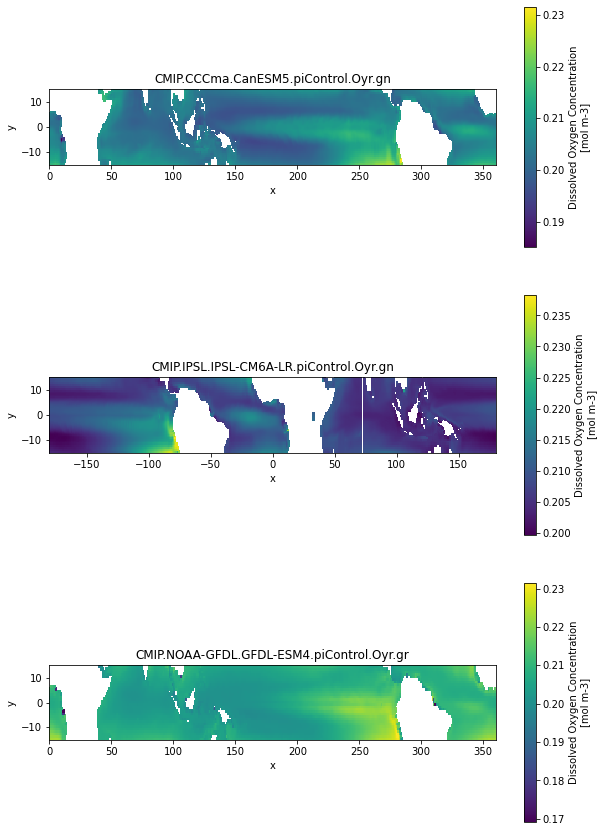

In [18]:
fig, axarr = plt.subplots(nrows=3, figsize=[10,15])
for ax, (k, ds) in zip(axarr.flat, dset_dict_processed1.items()):
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=-1)
    ds.o2.isel(time=0, lev=0).sel(y=slice(-15,15)).plot(ax=ax)
    ax.set_title(k)
    ax.set_aspect(2)

The naming and units are still inconsistent (not implemented yet) and the longitude is not consistent (we will deal with this below) But this is a big step forward. With the 'unprocessed' datasets this would have needed a lot more logic in the print loop.

<a id="lon"></a>
## Inconsistent longitude conventions
We saw above that not all models have a '0-360' longitude convention. We can fix this very quickly using `correct_lon`:

In [20]:
from cmip6_preprocessing.preprocessing import correct_lon

# same as above
def wrapper(ds):
    ds = ds.copy()
    ds = rename_cmip6(ds)
    ds = promote_empty_dims(ds)
    ds = broadcast_lonlat(ds)
    ds = replace_x_y_nominal_lat_lon(ds)
    ds = correct_lon(ds)
    return ds

# pass the preprocessing directly
dset_dict_processed2 = cat.to_dataset_dict(zarr_kwargs=z_kwargs,
                                           preprocess=wrapper)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 3 group(s)


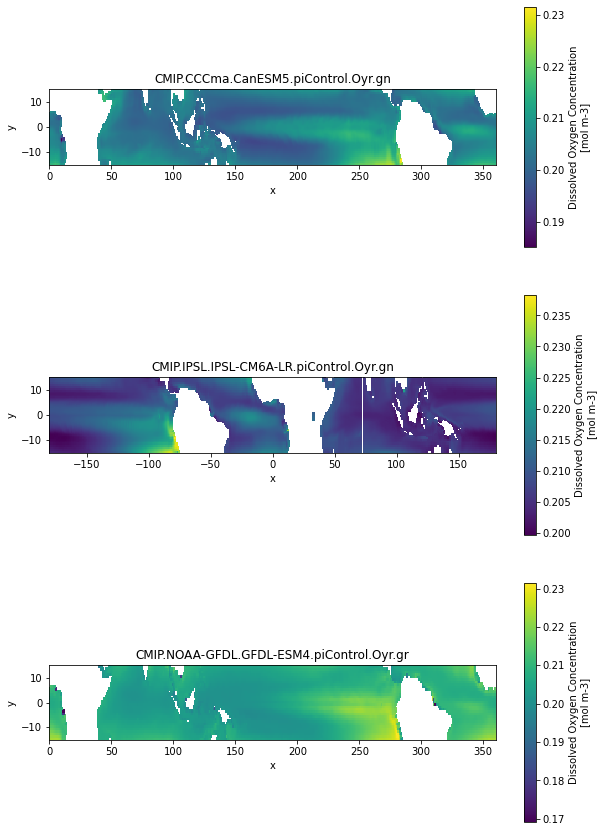

In [21]:
fig, axarr = plt.subplots(nrows=3, figsize=[10,15])
for ax, (k, ds) in zip(axarr.flat, dset_dict_processed2.items()):
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=-1)
    ds.o2.isel(time=0, lev=0).sel(y=slice(-15,15)).plot(ax=ax)
    ax.set_title(k)
    ax.set_aspect(2)

![](https://media.giphy.com/media/xT5LMQ8rHYTDGFG07e/giphy.gif)

<a id="units"></a>
## Inconsistent units

But of course this is not all. Some models, give the depth in centimeters (so far I have only seen this in the NCAR models). We can fix this with `correct_units`:

In [25]:
from cmip6_preprocessing.preprocessing import correct_units
query = dict(experiment_id = ['historical'],variable_id='thetao', grid_label=['gn'],source_id=['CESM2', 'CanESM5']
             )
cat = col.search(**query)
# raw data read in
dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs)
# fixed units
dset_dict_fixed_unit = cat.to_dataset_dict(zarr_kwargs=z_kwargs, preprocess=correct_units)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 2 group(s)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 2 group(s)
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converte

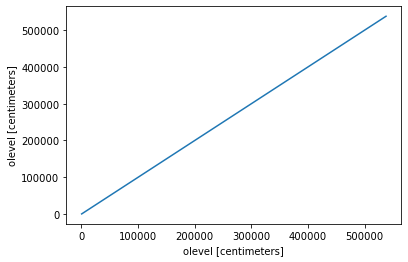

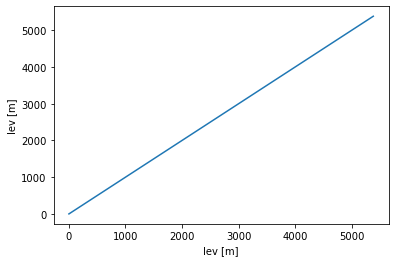

In [26]:
dset_dict['CMIP.NCAR.CESM2.historical.Omon.gn'].lev.plot()
plt.figure()
dset_dict_fixed_unit['CMIP.NCAR.CESM2.historical.Omon.gn'].lev.plot()

This helps tremendously when you are trying to slice a common depth from a series of models

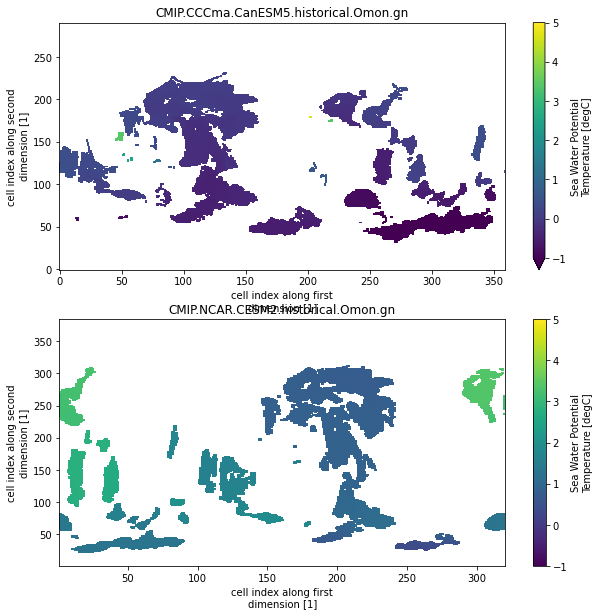

In [27]:
fig, axarr = plt.subplots(nrows=2, figsize=[10,10])
for ax, (k, ds) in zip(axarr.flat, dset_dict_fixed_unit.items()):
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    ds.thetao.isel(time=0).sel(lev=5000, method='nearest').plot(ax=ax, vmin=-1, vmax=5)
    ax.set_title(k)

As a comparison, for the unprocessed data this would have picked the depth at 50m for the `CESM2` model instead of 5000m:

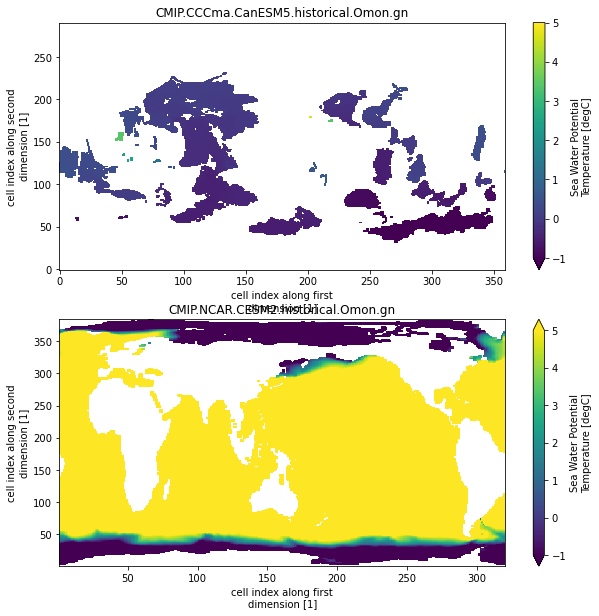

In [28]:
fig, axarr = plt.subplots(nrows=2, figsize=[10,10])
for ax, (k, ds) in zip(axarr.flat, dset_dict.items()):
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    ds.thetao.isel(time=0).sel(lev=5000, method='nearest').plot(ax=ax, vmin=-1, vmax=5)
    ax.set_title(k)

<a id="units"></a>
## Consistent CF bounds
Many of the CMIP6 models come with 'bound' dataarrays, that describe the extent of the finite grid cells.
For the longitude and latitude there are two conventions: 2-element 'bounds' (describing the width of a cell along the center) and 4 element 'verticies' (describing the 4 corner coordinates of the cell).
`cmip6_preprocessing` automatically renames these variables consistently and converts them so that every dataset has both conventions available.


In [38]:
from cmip6_preprocessing.preprocessing import correct_coordinates,parse_lon_lat_bounds, maybe_convert_bounds_to_vertex, maybe_convert_vertex_to_bounds

# same as above
def wrapper(ds):
    ds = ds.copy()
    ds = rename_cmip6(ds)
    ds = promote_empty_dims(ds)
    ds = broadcast_lonlat(ds)
    ds = replace_x_y_nominal_lat_lon(ds)
    ds = correct_lon(ds)
    ds = correct_coordinates(ds)
    ds = parse_lon_lat_bounds(ds)
    ds = maybe_convert_bounds_to_vertex(ds)
    ds = maybe_convert_vertex_to_bounds(ds)
    return ds

# pass the preprocessing directly
dset_dict_processed3 = cat.to_dataset_dict(zarr_kwargs=z_kwargs,
                                           preprocess=wrapper)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 2 group(s)


In [39]:
for k, ds in dset_dict_processed3.items():
    print(ds)

<xarray.Dataset>
Dimensions:        (bnds: 2, lev: 45, member_id: 35, time: 1980, vertex: 4, x: 360, y: 291)
Coordinates:
    lev_bounds     (time, lev, bnds) float64 dask.array<chunksize=(12, 45, 2), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat            (y, x) float32 dask.array<chunksize=(291, 360), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 291, 360), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 291, 360), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
  * time           (time) int64 0 708 1416 2148 ... 1443192 1443924 1444656
  * lev            (lev) float6

The vertex convention is consistent across models. The points are sorted from lower-left, upper-left, upper-right to lower-right.

<a id="combo"></a>
## TL;DR How to put it all together

To combine all these (or just some you like), you can create a wrapper function as above, or you can use the provided `combined_preprocessing`, which does all the above:

In [40]:
from cmip6_preprocessing.preprocessing import combined_preprocessing

# lets load a bunch more models this time
# load a few models to illustrate the problem
query = dict(experiment_id=['piControl', 'historical'], table_id='Oyr', 
             variable_id='o2', grid_label=['gn', 'gr'])
cat = col.search(**query)

print(cat.df['source_id'].unique())
dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs,
                                preprocess=combined_preprocessing)

['CanESM5-CanOE' 'CanESM5' 'ACCESS-ESM1-5' 'MPI-ESM-1-2-HAM'
 'IPSL-CM6A-LR' 'MIROC-ES2L' 'MPI-ESM1-2-HR' 'MPI-ESM1-2-LR' 'NorCPM1'
 'NorESM1-F' 'NorESM2-LM' 'NorESM2-MM' 'GFDL-ESM4']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 23 group(s)
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found


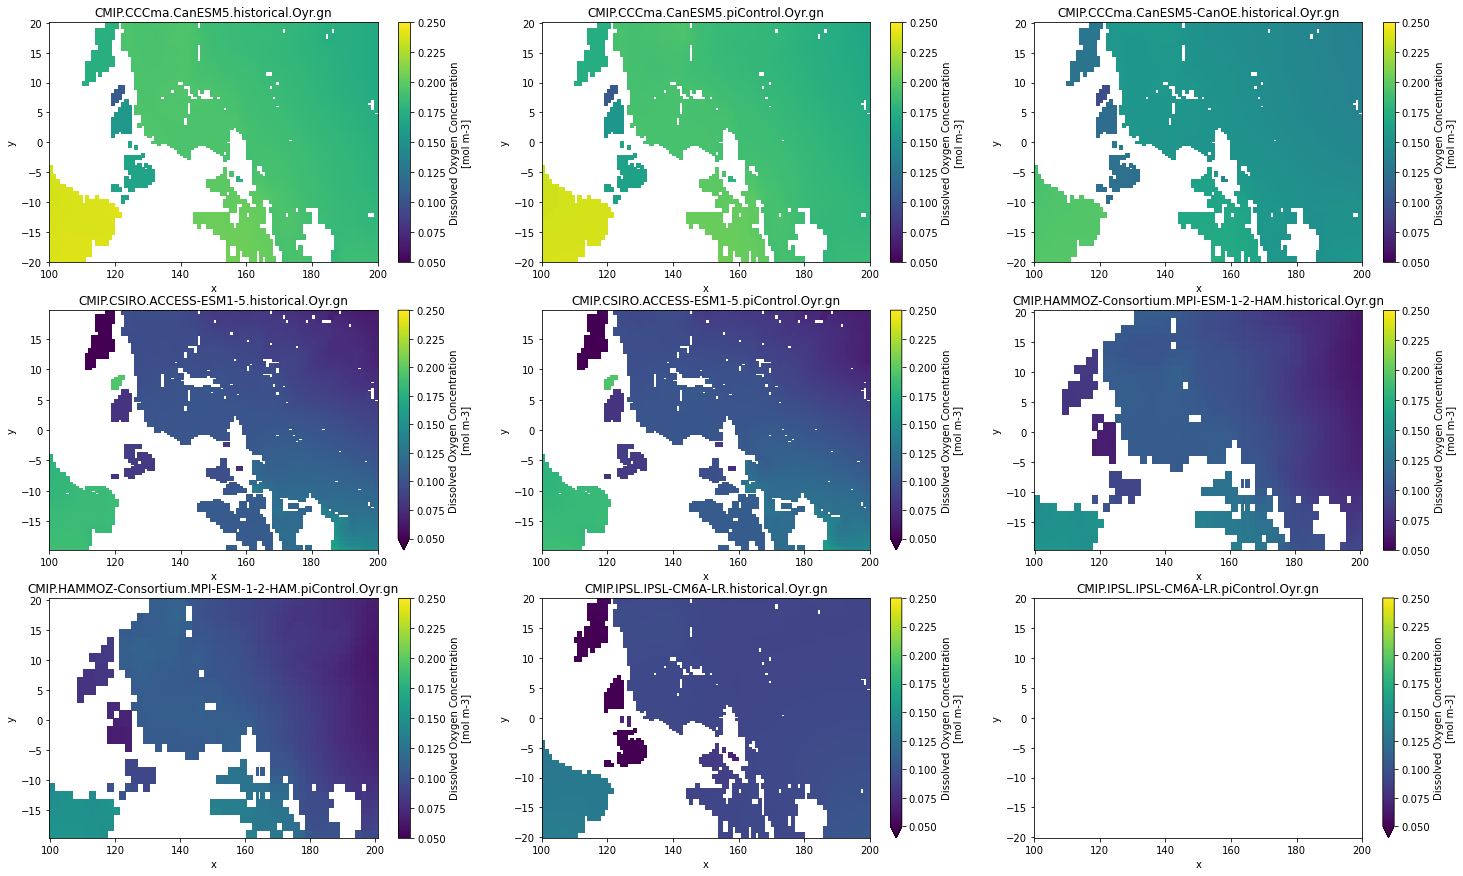

In [41]:
fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=[25,15])
for ax,(k, ds) in zip(axarr.flat,dset_dict.items()):
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    ds.o2.isel(time=0).sel(x=slice(100, 200), y=slice(-20,20)).interp(lev=2500).plot(ax=ax, vmax=0.25, vmin=0.05)
    ax.set_title(k)

## Appeal
**This is all in a very early development stage. If you notice errors, please try to isolate them by applying the single untility functions and then raise an issue on [github](https://github.com/jbusecke/cmip6_preprocessing/issues)**